# Project: Regression on high-dimensional datasets

### I. Introduction

Regression algorithms are a subset of machine learning algorithms where we want to predict the value of a response variable from features/explanatory variables.
The most know and basic regression algorithm is the simple linear OLS:

\begin{equation}
    Y = X \beta' + \epsilon
\end{equation}

In OLS, we use a quadratic loss function in order to estimate the parameter $\hat{\beta}$:

\begin{equation}
    \hat{\beta} = \arg \min_{\beta} \Sigma_{i}^{n} ( y_i - x_i \beta')^2
\end{equation}

The solution is for the OLS estimator can then be retrieved:

\begin{equation}
    \hat{\beta} = (X^{T} X)^{-1} X^{T} Y
\end{equation}

We can think of the coefficients $\hat{\beta}$ as the optimal weights to predict future values of y. There are several assumptions in the linear regression model, including the linearity between reponse (y) and explanatory (X) variables. 

$\hat{Y}$ is the orthogonal projection of $Y$ on the space spanned by $X$: $\hat{Y}= X(X^{T} X)^{-1} X^{T} Y$ where $P=X(X^{T} X)^{-1} X^{T}$ is the orthogonal projection matrix to the space spanned by $X$. If $X$ is "living" in a space of higher dimensions than $Y$ and projecting $Y$ to to the space spanned by $X$ is not feasible.
From another point of view, if $p>N$, then $(X^{T} X)^{-1}$ will not be invertible (or only with a pseudo-inverse method).

Hence in this notebook, I would like to focus on the constraint of dimensions on regression problems. In this context, I have chosen two algorithms to help me tackle the dimension problem: principal component regression and Lasso regression, as well as two dataset on which I will train my models: a real dataset of DNA microarray
and a synthetic linear regression model dataset.

### II. Machine Learning Algorithms
#### 1. Principal Component Regression
We have seen that OLS algorithm breaks down for high dimensional data. One way to circumvent this problem is to use a dimension reduction technique such as principal component analysis (PCA). The combination of PCA and OLS is also referred to as principal components regression.

In PCA, we would like to reduce the number of variables . The idea behind PCA is to project the features (X) on a lower dimensional vector space where the basis or coordinate system of this space is formed by the new principal component variables. The first principal component is defined to capture the highest variance, the second principal component 

Thus, by combining OLS with this reduction technique, we can expect to be a better prediction mechanism than standard OLS. However one inconvenient of PCA is the interpretability of the new principal componenet variables. But we are still able to make predictions and transform new samples to the principal coordinate system.

#### 2. Lasso Regression
The Lasso method, also known as basis pursuit, is a regression algorithm incoporating a shrinkage or regularization component in the error minimization procedure. In other words, the Lasso procedure does a continiuous subset selection of the features and set the rest to zero. Thus it produces a model that is interpretable and has possibly lower prediction error.

In the Lasso procedure, the estimate is chosen such as to minimize the sum of squared residuals (as in OLS) subject to a size penalty:

\begin{equation}
    \hat{\beta} = \arg \min_{\beta} { \frac{1}{2} \Sigma_{i}^{N} ( y_i - \beta_0 - \Sigma_{j}^{p} x_ij \beta_j)^2 + \lambda \Sigma_{j}^{p} |\beta_j| } 
\end{equation}

The procedure is similar to the ridge regression, except that here we use an *L1* penalization criteria insteat of *L2*. In the training of our model, we will want to choose an optimal for $\lambda$, i.e. a value that reduces the prediction error.




### III. Dataset creation and description
#### 1. Real dataset: Diffuse large B-cell lymphoma (DLBCL)
The dataset is a microarray example. It is taken originally from Rosenwald et al. (2002) and it can be retrieved in the R package "LPS". It consits of 60 samples from patients with diffuse large B-cell lymphoma (DLBCL) and gene expression measurements for 7399 genes. Hence this is clearly a high-dimensional situation, as we have many more features (7399) than observations (60).

DLBCL are a type of lymphoma that are associated to a cancer that forms in white blood cells called lymphocytes. Lymphocytes produce anitbodies that help our body fight bacterias and virus. B-cell lymphoma can't fight infections well and spread to other parts of your body.
The response variable in this dataset is the survival time in month of a patient. This surival time is either observed, i.e. the observation period contains the death event, or right censored, i.e. the observation period doesn't contain the death event.

The objective of Rosenwald et al. was to find the set of genes that will predict the survival of a patient. The study of these gene could then be useful in the choice of treatments or to understand the biological basis of the disease. 

#### 2. Synthetic dataset: Linear regression with N=100 and p=1000
The synthetic dataset consists of a linear regression model with 100 observations/samples and 1000 features. The sklearn.dataset library enables us to easily produce such a model.
Furthermore we specify that out of the 100 features only 10 are informative (i.e. features that are actually used by sklearn the build the model) and the standard deviation for the gaussian noise term is equal to 1. This renders the synthetic dataset sparse, in the sense that 90% of the features have no predictive power.

### IV. Training of the models

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score, max_error

#### 1. Real dataset: Diffuse large B-cell lymphoma (DLBCL)

In [17]:
# Load the survival time dataset
lcs_X = pd.read_csv("rosenwald.csv", index_col=0)
lcs_y = pd.read_csv("rosenwald_cli.csv", index_col=0)

In [18]:
# Treat the missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(lcs_X)
lcs_X = imp.transform(lcs_X)

In [19]:
# Split the dataset on 80%/20% basis
lcs_X_train, lcs_X_test, lcs_y_train, lcs_y_test = train_test_split(lcs_X, lcs_y.values, test_size=0.2, random_state=2)

I have split the data randomly on 80/20 basis into training set (48x7399) and test set (12x7399).

In [20]:
# Principal Component Regression
# We want 75% of variance explained for our model
pca_lcs = PCA(0.75)
pca_lcs.fit(lcs_X_train)
pca_X_train = pca_lcs.transform(lcs_X_train)
pca_X_test = pca_lcs.transform(lcs_X_test)
# We can now fit our OLS regression:
reg = LinearRegression()
reg.fit(pca_X_train, lcs_y_train)
inS_reg_pred = reg.predict(pca_X_train)
outS_reg_pred = reg.predict(pca_X_test)

In [21]:
# Fit Lasso regression model
regr = Lasso()
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 10000, normalize = True)
lassocv.fit(lcs_X_train, lcs_y_train.ravel())
regr.set_params(alpha=lassocv.alpha_)
regr.fit(lcs_X_train, lcs_y_train.ravel())
inS_regr_pred = regr.predict(lcs_X_train)
outS_regr_pred = regr.predict(lcs_X_test)

In [22]:
# We now compute MSE, MAE and R2 scores
lcs_mse_df = pd.DataFrame({
    "PCR": {"InSample": np.round(mean_squared_error(lcs_y_train, inS_reg_pred), 2),
              "OutSample": np.round(mean_squared_error(lcs_y_test, outS_reg_pred), 2),},
    "LASSO":{"InSample": np.round(mean_squared_error(lcs_y_train,inS_regr_pred),2),
             "OutSample": np.round(mean_squared_error(lcs_y_test,outS_regr_pred),2)},
})
lcs_mae_df = pd.DataFrame({
    "PCR": {"InSample": np.round(mean_absolute_error(lcs_y_train, inS_reg_pred), 2),
              "OutSample": np.round(mean_absolute_error(lcs_y_test, outS_reg_pred), 2),},
    "LASSO":{"InSample": np.round(mean_absolute_error(lcs_y_train,inS_regr_pred),2),
             "OutSample": np.round(mean_absolute_error(lcs_y_test,outS_regr_pred),2)},
})
lcs_r2_df = pd.DataFrame({
    "PCR": {"InSample": np.round(explained_variance_score(lcs_y_train, inS_reg_pred), 2),
              "OutSample": np.round(explained_variance_score(lcs_y_test, outS_reg_pred), 2),},
    "LASSO":{"InSample": np.round(explained_variance_score(lcs_y_train,inS_regr_pred),2),
             "OutSample": np.round(explained_variance_score(lcs_y_test,outS_regr_pred),2)},
})

In [23]:
print("")
print("Mean squared error")
print("------------------------")
print(lcs_mse_df)
print("")
print("Mean absolute error")
print("------------------------")
print(lcs_mae_df)
print("")
print("R2 score")
print("------------------------")
print(lcs_r2_df)


Mean squared error
------------------------
             PCR  LASSO
InSample   13.56   1.82
OutSample  14.27  28.33

Mean absolute error
------------------------
            PCR  LASSO
InSample   3.08   1.09
OutSample  3.19   4.50

R2 score
------------------------
            PCR  LASSO
InSample   0.38   0.92
OutSample -0.58  -2.40


We can see that the Lasso procedure outperforms PCR in-sample. Lasso has a relatively low MSE and high R2 score of 0.92 in the training data. However for the test data, both procedures seem to break down. The Lasso MSE jumps to 28.33, and the R2 score becomes even negative for both lasso and PCR. This could indicate that a linear model is not adapted to our data.

PCR - number of chosen components :  22


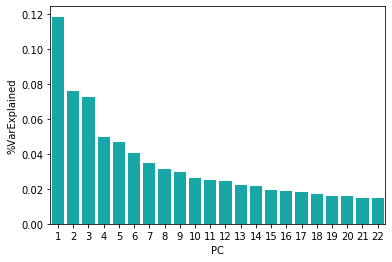

In [24]:
print('PCR - number of chosen components : ', len(pca_lcs.explained_variance_ratio_))
var_lcs_df = pd.DataFrame({'%VarExplained':pca_lcs.explained_variance_ratio_, 
                       'PC':np.arange(1,len(pca_lcs.explained_variance_ratio_)+1,1)})
sns.barplot(x='PC',y="%VarExplained", data=var_lcs_df, color="c")

The PCR has selected 22 components (out of 7399) to explain 75% of the variance. This is actually quite interesting. However it seems that the linear regression might not be the best algorithm for this problem.

#### 2. Synthetic dataset: Linear regression with N=100 and p=1000

In [25]:
# Create the synthetic dataset and split into training and test sets:
synth_X, synth_y = make_regression(n_samples=100, n_features=1000, n_informative=5, 
                                   noise=1, random_state=0)
synth_X_train, synth_X_test, synth_y_train, synth_y_test = train_test_split(
    synth_X, synth_y, test_size=0.2, random_state=2)

In [26]:
# Principal Component Regression
# We want 75% of variance explained
pca_sy = PCA(0.75)
pca_sy.fit(synth_X_train)
pca_X_sy_train = pca_sy.transform(synth_X_train)
pca_X_sy_test = pca_sy.transform(synth_X_test)
# We can now fit our OLS regression:
reg_sy = LinearRegression()
reg_sy.fit(pca_X_sy_train, synth_y_train)
inS_reg_sy_pred = reg_sy.predict(pca_X_sy_train)
outS_reg_sy_pred = reg_sy.predict(pca_X_sy_test)

In [27]:
# Fit Lasso regression model
regr_sy = Lasso()
lassocv_sy = LassoCV(alphas = None, cv = 10, max_iter = 1000000, normalize = True)
lassocv_sy.fit(synth_X_train, synth_y_train)
regr_sy.set_params(alpha=lassocv.alpha_)
regr_sy.fit(synth_X_train, synth_y_train)
inS_regr_sy_pred = regr_sy.predict(synth_X_train)
outS_regr_sy_pred = regr_sy.predict(synth_X_test)

In [28]:
synth_mse_df = pd.DataFrame({
    "OLS": {"InSample": np.round(mean_squared_error(synth_y_train,inS_reg_sy_pred),2),
              "OutSample": np.round(mean_squared_error(synth_y_test,outS_reg_sy_pred),2)},
    "LASSO":{"InSample": np.round(mean_squared_error(synth_y_train,inS_regr_sy_pred),2),
             "OutSample": np.round(mean_squared_error(synth_y_test,outS_regr_sy_pred),2)},
})

synth_mae_df = pd.DataFrame({
    "OLS": {"InSample": np.round(mean_absolute_error(synth_y_train,inS_reg_sy_pred),2),
              "OutSample": np.round(mean_absolute_error(synth_y_test,outS_reg_sy_pred),2)},
    "LASSO":{"InSample": np.round(mean_absolute_error(synth_y_train,inS_regr_sy_pred),2),
             "OutSample": np.round(mean_absolute_error(synth_y_test,outS_regr_sy_pred),2)},
})

synth_r2_df = pd.DataFrame({
    "OLS": {"InSample": np.round(r2_score(synth_y_train,inS_reg_sy_pred),2),
              "OutSample": np.round(r2_score(synth_y_test,outS_reg_sy_pred),2)},
    "LASSO":{"InSample": np.round(r2_score(synth_y_train,inS_regr_sy_pred),2),
             "OutSample": np.round(r2_score(synth_y_test,outS_regr_sy_pred),2)},
})

In [29]:
print("")
print("Mean squared error")
print("------------------------")
print(synth_mse_df)
print("")
print("Mean absolute error")
print("------------------------")
print(synth_mae_df)
print("")
print("R2 score")
print("------------------------")
print(synth_r2_df)


Mean squared error
------------------------
                OLS  LASSO
InSample    8664.40   1.42
OutSample  36675.44   3.51

Mean absolute error
------------------------
              OLS  LASSO
InSample    73.62   0.93
OutSample  156.14   1.42

R2 score
------------------------
            OLS  LASSO
InSample   0.71    1.0
OutSample -0.05    1.0


Here, we see perfect results for the Lasso procedure and outperforms the PCR in-sample and out-of-sample. Both the MSE and MAE of the lasso procedure remains small when moving out-of-sample, and the R2 score of 1 in and out-of-sample. The shrinkage and variable selection works perfectly well for this problem. 

In [30]:
print('PCR - number of chosen componenets : ', len(pca_sy.explained_variance_ratio_))

PCR - number of chosen componenets :  52


In order to capture 75% of the variance explained by the features, the PCR has selected 52 features out of the 1000 initial features. This is still far from the real 10 features that are driving this dataset.

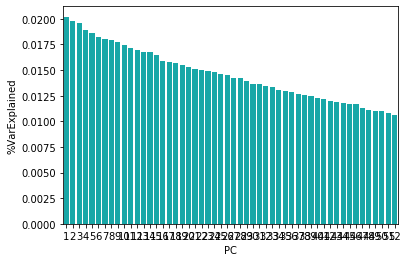

In [31]:
var_sy_df = pd.DataFrame({'%VarExplained':pca_sy.explained_variance_ratio_, 
                       'PC':np.arange(1,len(pca_sy.explained_variance_ratio_)+1,1)})
sns.barplot(x='PC',y="%VarExplained", data=var_sy_df, color="c")

As we can see in the figure above, the first principal component is able to explain only 2% of the data. The PCA is failing in this case.

### V. Conclusion
In this project, I have tried to analyze two high dimensional datasets using principal component regression and lasso regression.
Overall the lasso seems to behave better than PCR on high dimensional sparse datasets. Lasso seems particularly well suited for selecting the driving features of a high dimensional sparse dataset and has low predictiob error.